In [1]:
import pickle
import os
from collections import Iterable
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()
plt.rcParams.update({'font.size': 22})

<ipython-input-1-f22033fd6734>:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [2]:
def flatten(lis):
     for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
            for x in flatten(item):
                yield x
        else:        
            yield item
            
def find(lst, s):
    return [i for i, x in enumerate(lst) if x==s]

def keys_exists(element, *keys):
    '''
    Check if *keys (nested) exists in `element` (dict).
    '''
    if not isinstance(element, dict):
        raise AttributeError('keys_exists() expects dict as first argument.')
    if len(keys) == 0:
        raise AttributeError('keys_exists() expects at least two arguments, one given.')

    _element = element
    for key in keys:
        try:
            _element = _element[key]
        except KeyError:
            return False
    return True

In [3]:
def compute_aggreated_results(algorithm, dataset, path='../results', err_metric='mase'):
    results_dict={}
    for file in [path for path in os.listdir(path) if algorithm in path and dataset in path]:
        with open(f'{path}/{file}', 'rb') as handle:
            flatten_file_name = list(flatten([i.split('.') for i in file.split('_')]))
            idx_dataset_name = find(flatten_file_name, dataset)[0]
            sample = flatten_file_name[idx_dataset_name+1:-1][-1]
            version = flatten_file_name[idx_dataset_name+1:-1][-2]
            transformation = '_'.join(flatten_file_name[idx_dataset_name+1:-1][:-2])
            if not keys_exists(results_dict, transformation):
                results_dict[transformation] = {}
            if not keys_exists(results_dict, transformation, version): 
                results_dict[transformation][version] = {}
            if not keys_exists(results_dict, transformation, version, sample):    
                results_dict[transformation][version][sample] = {}

            results_dict[transformation][version][sample] = pickle.load(handle)
        handle.close()

    # shape=(transformation, version, sample, metric, dim)
    # metric = mase, rmse
    # dim = bottom, total, state, gender, legal, all

    df = pd.DataFrame.from_dict({(i,j, k, l): results_dict[i][j][k][l] 
                               for i in results_dict.keys() 
                               for j in results_dict[i].keys()
                               for k in results_dict[i][j].keys()
                               for l in results_dict[i][j][k].keys()},
                           orient='index')

    df_err = df[np.in1d(df.index.get_level_values(3), [err_metric])]
    df_clean = df_err.mean(level=(0,1,2)).stack(level=0).to_frame()
    df_clean = df_clean.reset_index()
    df_clean.columns = ['transformation', 'version', 'sample', 'group', err_metric]
    
    return df_clean

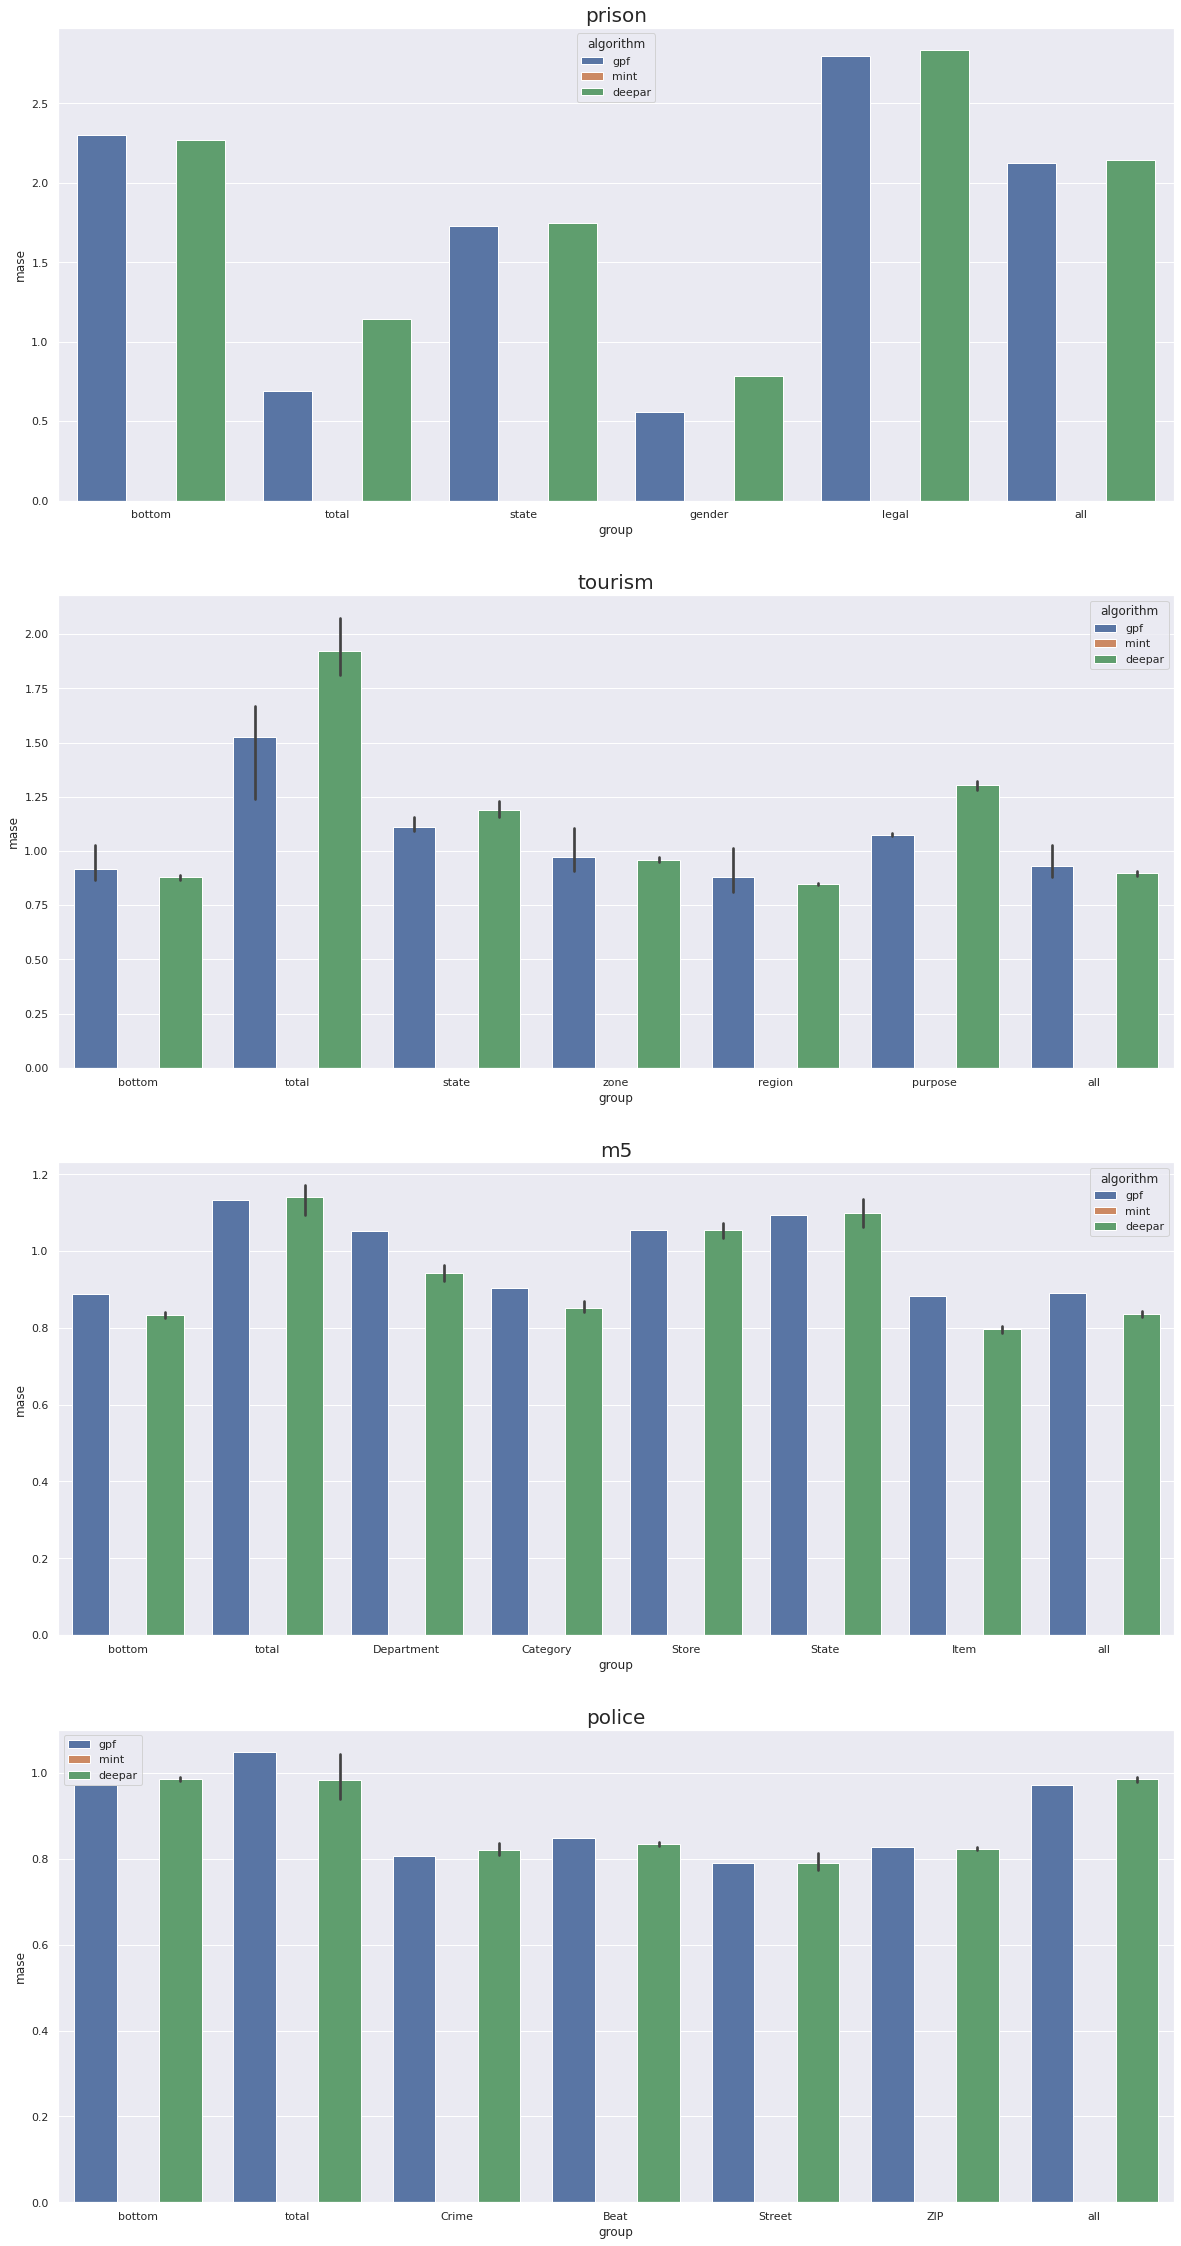

In [4]:
datasets = ['prison', 'tourism', 'm5', 'police']
df_orig_list = []
for d in datasets:
    df_gpf = compute_aggreated_results(algorithm='gpf', dataset=d)
    df_mint = compute_aggreated_results(algorithm='mint', dataset=d)
    df_deepar = compute_aggreated_results(algorithm='deepar', dataset=d)
    df_gpf['algorithm']='gpf'
    df_mint['algorithm']='mint'
    df_deepar['algorithm']='deepar'
    df = pd.concat([df_gpf, df_mint, df_deepar])
    df_orig = df[df['version']=='orig'].reset_index().drop(['index'], axis=1)
    #df_orig = df_orig.groupby(['group', 'algorithm']).min()['mase'].reset_index()
    # sort values by algorithm to plot gpf -> mint -> deepar
    sorter = ['gpf', 'mint', 'deepar']
    df_orig.algorithm = df_orig.algorithm.astype("category")
    df_orig.algorithm.cat.set_categories(sorter, inplace=True)
    df_orig_list.append(df_orig)

_, ax = plt.subplots(len(datasets), 1, figsize=(20, 10*len(datasets)))
ax = ax.ravel()
for i in range(len(datasets)):
    fg = sns.barplot(x='group', 
                      y='mase',
                      hue='algorithm',
                      data=df_orig_list[i], 
                      ax=ax[i])
    ax[i].set_title(datasets[i], fontsize=20)
plt.legend()
plt.show()